## Modeling of daily price fluctuations

Aim:
- Check daily absolut and relative changes
- Find a distribution which models the realtive daily changes
- Calculate the probability of the change rate at day on which Musk posted a tweet under the fitted distribution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tueplots import bundles
plt.rcParams.update(bundles.neurips2021(usetex=False))

## 1. Check daily absolut and relative changes

In [2]:
# Import dogecoin data
df_dog = pd.read_csv("../dat/crypto-stocks/doge-coin-daily.csv")

# Check that date order is right
df_dog.Date = pd.to_datetime(df_dog.Date)
df_dog = df_dog.sort_values("Date")

day_shift = 1

### Investigate daily absolut changes 

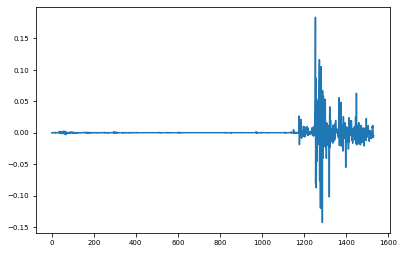

In [3]:
df_dog["Daily Changes"] = (df_dog.Close - df_dog.Close.shift(day_shift))

plt.plot(df_dog["Daily Changes"])
plt.show()

The plot shows clear stationarity. The value if a datapoint depends on where a datapoint is in the timeseries. Therefore we should look at realitve data which removes this effect. We use daily value change rate.

### Investigate daily relative change rate

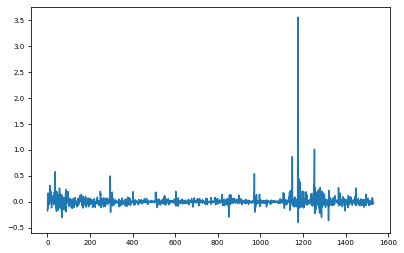

In [4]:
df_dog["Daily Changes (%)"] = (df_dog.Close - df_dog.Close.shift(day_shift)) / df_dog.Close.shift(day_shift)

plt.plot(df_dog["Daily Changes (%)"])
plt.show()

We could not observe that strong stationarities, and therefore use this approach.

### Target distribution

Our aim is to fit a distribution, which fits our empirical distribution best. Here is how our empirical distribtuion looks like:

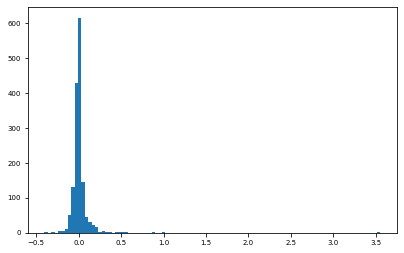

In [5]:
plt.hist(df_dog["Daily Changes (%)"], bins = 100)
plt.show()

From visual inspection we hypothesis, that the distribtion could be modeled by either a normal, laplace or t-student distribution. Next we check how well those distributions fits the data.

## 2. Testing different distributions

### Normal Distribution

Optimization terminated successfully.
         Current function value: -1785.648425
         Iterations: 43
         Function evaluations: 84


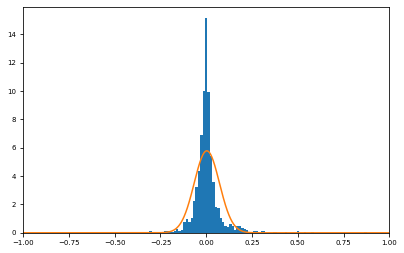

In [11]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

param_mean = 0
param_std = 0.2
params =[param_mean, param_std]


X = df_dog["Daily Changes (%)"].values[1:]


def get_loss_norm(params, X):

    p_all = norm.pdf(X,loc=params[0],scale=params[1])
    p_all = np.array(p_all) + 0.000000000001
    neg_log_like = -np.log(p_all)
    return neg_log_like.sum()  


res = minimize(get_loss_norm, params, X, 
               method='Nelder-Mead',
               options={'disp': True},
               bounds = ((-0.5, 0.5), (0.0005, 3)))
res

plt.hist(df_dog["Daily Changes (%)"], density=True,bins = 300)
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,res.x[0],res.x[1]))
plt.xlim(-1,1)
plt.show()

### Laplace Distribution

/Users/jochenluithardt/miniconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Optimization terminated successfully.
         Current function value: -2155.229416
         Iterations: 43
         Function evaluations: 82


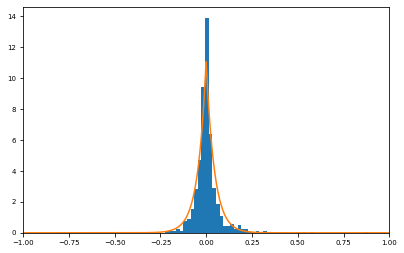

In [12]:
from scipy.stats import laplace
from scipy.optimize import minimize

param_mean = 0
param_std = 0.5
params =[param_mean, param_std]


X = df_dog["Daily Changes (%)"].values[1:]



def get_loss_laplace(params, X):

    p_all = laplace.pdf(X,loc=params[0],scale=params[1])
    p_all = np.array(p_all)
    neg_log_like = -np.log(p_all)
    return neg_log_like.sum()  


res = minimize(get_loss_laplace, params,X, 
               method='Nelder-Mead',
               options={'disp': True},
               bounds = ((-0.5, 0.5), (0.0005, 3)))

plt.hist(df_dog["Daily Changes (%)"], density=True,bins = 200)
x_axis = np.arange(-1, 1, 0.001)
plt.plot(x_axis, laplace.pdf(x_axis,res.x[0],res.x[1]))
plt.xlim(-1,1)
plt.show()

### t-student Distribution

/Users/jochenluithardt/miniconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:533: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


Optimization terminated successfully.
         Current function value: -2314.543094
         Iterations: 141
         Function evaluations: 247


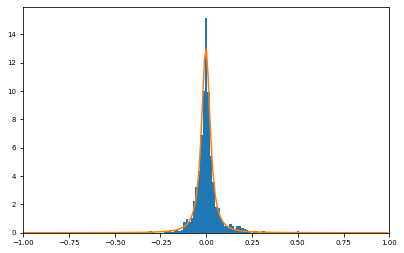

In [13]:
from scipy.stats import t
from scipy.optimize import minimize
import numpy as np

param_mean = 0
param_std = 0.2
param_df = 2
params =[param_mean, param_std,param_df]


X = df_dog["Daily Changes (%)"].values[1:]


def get_loss_t(params, X):
    p_all = []
    p_all = t.pdf(X,loc=params[0],scale=params[1], df=params[2])
    p_all = np.array(p_all)
    neg_log_like = -np.log(p_all)
    return neg_log_like.sum()  


res = minimize(get_loss_t, params,X,
               method='Nelder-Mead',
               options={'disp': True},
               bounds = ((-0.5, 0.5), (0.0005, 3),  (1, 10)))

plt.hist(df_dog["Daily Changes (%)"], density=True,bins = 300)
x_axis = np.arange(-1, 1, 0.01)
plt.plot(x_axis, t.pdf(x_axis,loc=res.x[0],scale=res.x[1], df=res.x[2] ))
plt.xlim(-1,1)
plt.show()

In sum the normal distribution seems a bit off, but the other to are looking very good. In order to compaire the model statistically, we use non parametric bootstrapping next.

## 3. Model compairison based on non-parametric bootstrap samples

In [14]:
from tqdm.notebook import tqdm


def get_loss_t(params, X):
    p_all = []
    p_all = t.pdf(X,loc=params[0],scale=params[1], df=params[2])
    p_all = np.array(p_all)
    neg_log_like = -np.log(p_all)
    return neg_log_like.sum()  

def bootstrap (pd_series, n_bootstraps,params, loss_function):

    neg_log_liklihood = []
    parameters = []
    for i in tqdm(range(n_bootstraps)):

        X = pd_series.iloc[1:].sample(n = len(pd_series),replace = True).values

        res = minimize(loss_function, params,X,
                       method='Nelder-Mead',
                       bounds = ((-0.5, 0.5), (0.0005, 3),  (1, 10)))
        neg_log_liklihood.append(res.fun)
        parameters.append(res.x)
    return np.array(neg_log_liklihood), np.stack(np.array(parameters))

### Bootstrap normal distribution

In [20]:
n_bootstraps = 900

param_mean = 0
param_std = 0.2
params =[param_mean, param_std]

norm_losses, norm_params = bootstrap(df_dog["Daily Changes (%)"], 
                                     n_bootstraps, 
                                     params, 
                                     get_loss_norm)

### Bootstrap laplace distribution

In [21]:
n_bootstraps = 900

param_mean = 0
param_std = 0.2
params =[param_mean, param_std]

laplace_losses, laplace_params = bootstrap(df_dog["Daily Changes (%)"], 
                                     n_bootstraps, 
                                     params, 
                                     get_loss_laplace)

### Bootstrap t-student distribution

In [22]:
n_bootstraps = 900

param_mean = 0
param_std = 0.2
param_df = 2
params =[param_mean, param_std, param_df]

t_losses, t_params = bootstrap(df_dog["Daily Changes (%)"], 
                                     n_bootstraps, 
                                     params, 
                                     get_loss_t)

### Calculate AIC for each distribution

In [23]:
K_paramaters = 2
laplace_aic = 2*laplace_losses + 2 * K_paramaters

K_paramaters = 2
norm_aic = 2*norm_losses + 2 * K_paramaters

K_paramaters = 2
t_aic = 2*t_losses + 2 * K_paramaters

### Plot AIC of each distribtuion

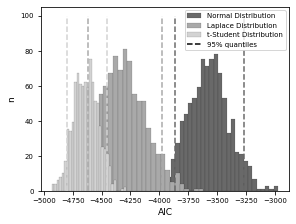

In [33]:

fig, ax = plt.subplots(figsize=[4,3])

plt.hist(norm_aic, bins = 30, label ="Normal Distribution", color ="dimgray", edgecolor='black', linewidth=0.1)
plt.hist(laplace_aic, bins = 30, label ="Laplace Distribution", color ="darkgray",edgecolor='black', linewidth=0.1)
plt.hist(t_aic, bins = 30, label ="t-Student Distribution", color ="lightgray",edgecolor='black', linewidth=0.1)


plt.vlines(np.quantile(norm_aic, 0.95), ymin =0, ymax =100, linestyles="dashed", color ="dimgray")
plt.vlines(np.quantile(norm_aic, 0.05), ymin =0, ymax =100, linestyles="dashed", color ="dimgray")


plt.vlines(np.quantile(laplace_aic, 0.95), ymin =0, ymax =100, linestyles="dashed", color ="darkgray")
plt.vlines(np.quantile(laplace_aic, 0.05), ymin =0, ymax =100, linestyles="dashed", color ="darkgray")



plt.vlines(np.quantile(t_aic, 0.95), ymin =0, ymax =100, linestyles="dashed", color ="lightgray")
plt.vlines(np.quantile(t_aic, 0.05), ymin =0, ymax =100, linestyles="dashed", color ="lightgray")

plt.vlines(np.quantile(t_aic, 0.05), ymin =0, ymax =0, label="95% quantiles", linestyles="dashed", color ="black")


plt.legend()
plt.xlabel('AIC')
plt.ylabel('n')
plt.show()

fig.savefig('Plot_distribution_AIC/DailyRelativeChangeDistribution.pdf', dpi=350)
fig.savefig('Plot_distribution_AIC/DailyRelativeChangeDistribution.png', dpi=350)

AIC of the bootstraped distributions shows that, t-Student and Laplace distributions could fit the data better than the normal distribution. But between t-Student and Laplace it is hard to make a distriction. Therfore t-tests between the AIC of the groups are performed and get corrected for multicompairsion with a bonferoni correction.

### T-test for best distributions 

In [231]:
from scipy import stats

alpha = 0.05 * 1/3
print("Adjusted alpha value, based on Bonferoni correction: ",alpha)

t_result = stats.ttest_ind(norm_aic, laplace_aic)
print("Laplace have a better than normal AIC with a p-value of:",str(t_result[1]))

t_result = stats.ttest_ind(norm_aic, t_aic)
print("t-student have a better than normal AIC with a p-value of:",str(t_result[1]))

t_result = stats.ttest_ind(t_aic, laplace_aic)
print("t-student have a better than Laplace AIC with a p-value of:",str(t_result[1]))

Adjusted alpha value, based on Bonferoni correction:  0.016666666666666666
Laplace have a better than normal AIC with a p-value of: 1.8695367555077873e-68
t-student have a better than normal AIC with a p-value of: 2.2954224378838543e-110
t-student have a better than Laplace AIC with a p-value of: 1.036835563827625e-26


The t-student distribtion seem to have is signtificantly better then the other two distributions. Therefore now the parameter of the t-student distribtions is analyzed, in order to check for identifiability of the parameters. 

### Investigate identifiability of t-student distribution

#### First Parameter

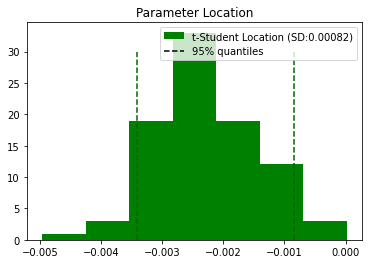

In [220]:
plt.hist(t_params[:,0], bins = 7, label ="t-Student Location (SD:"+str(round(np.std(t_params[:,0]),5))+")", color ="green")
plt.vlines(np.quantile(t_params[:,0], 0.95), ymin =0, ymax =30, linestyles="dashed", color ="darkgreen")
plt.vlines(np.quantile(t_params[:,0], 0.05), ymin =0, ymax =30, linestyles="dashed", color ="darkgreen")


plt.vlines(np.quantile(t_params[:,0], 0.95), ymin =0, ymax =0, label="95% quantiles", linestyles="dashed", color ="black")
plt.title("Parameter Location")
plt.legend()
plt.show()

#### Second Parameter

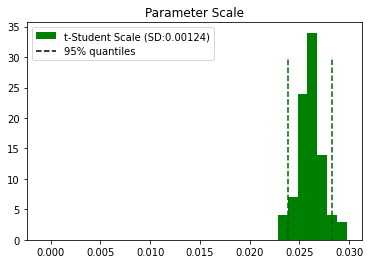

In [221]:
plt.hist(t_params[:,1], bins = 7, label ="t-Student Scale (SD:"+str(round(np.std(t_params[:,1]),5))+")", color ="green")
plt.vlines(np.quantile(t_params[:,1], 0.95), ymin =0, ymax =30, linestyles="dashed", color ="darkgreen")
plt.vlines(np.quantile(t_params[:,1], 0.05), ymin =0, ymax =30, linestyles="dashed", color ="darkgreen")

plt.vlines(np.quantile(t_params[:,0], 0.95), ymin =0, ymax =0, label="95% quantiles", linestyles="dashed", color ="black")
plt.title("Parameter Scale")
plt.legend()
plt.show()

#### Third Parameter

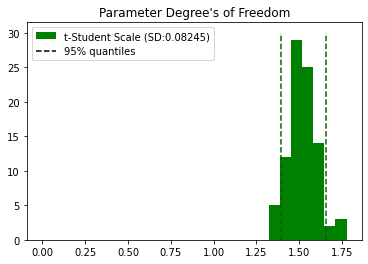

In [222]:
plt.hist(t_params[:,2], bins = 7, label ="t-Student Scale (SD:"+str(round(np.std(t_params[:,2]),5))+")", color ="green")
plt.vlines(np.quantile(t_params[:,2], 0.95), ymin =0, ymax =30, linestyles="dashed", color ="darkgreen")
plt.vlines(np.quantile(t_params[:,2], 0.05), ymin =0, ymax =30, linestyles="dashed", color ="darkgreen")

plt.vlines(np.quantile(t_params[:,0], 0.95), ymin =0, ymax =0, label="95% quantiles", linestyles="dashed", color ="black")
plt.title("Parameter Degree's of Freedom")
plt.legend()
plt.show()

Parameters are normally distributed which indicates that identifiability of the paramters. Finaly we test the model fit with the Kolmogorov-Smirnov-Test .

### Testing for data fit via Kolmogorov-Smirnov-Test 

In [266]:
t_params_final = t_params.mean(axis = 0)

In [261]:
X = df_dog["Daily Changes (%)"].values[1:]

t_student = t.cdf(X,loc=t_params_final[0],scale=t_params_final[1],df=t_params_final[2])
print("t-student distribution is highly likly similar to our empircal distributiom:\n",stats.kstest(X, t_student))

t-student distribution is highly likly similar to our empircal distributiom:
 KstestResult(statistic=0.8536903984323971, pvalue=0.0)


The test is highly significant which, indicated that our distrubtion is a good aproximation of our data. Therefore t-student distribtion was used in the following analysis.

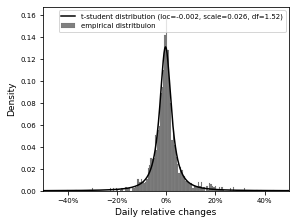

In [327]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=[4,3])

plt.hist(df_dog["Daily Changes (%)"]*100,edgecolor='black', linewidth=0.05, density=True,bins = 700,color ="gray", label="empirical distritbuion")
x_axis = np.arange(-1, 1, 0.0001)
plt.plot(x_axis*100, t.pdf(x_axis,
                           loc=t_params_final[0],
                           scale=t_params_final[1], 
                           df=t_params_final[2])/100,
        label=f"t-student distribution (loc=%s, scale=%s, df=%s)" % (round(t_params_final[0],3),round(t_params_final[1],3),round(t_params_final[2],4)), 
         color ="black")
plt.xlim(-50,50)
plt.xlabel("Daily relative changes")
plt.ylabel("Density")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()
fig.savefig('Plot_daily_changes_analysis/DailyRelativeChangeDistribution.pdf', dpi=350)
fig.savefig('Plot_daily_changes_analysis/DailyRelativeChangeDistribution.png', dpi=350)

## 4. Using fitted distributions to estimate change rate probability on tweet days

### Getting dates on which Elon Musk posts a tweet

In [262]:
# Read data
df_merged = pd.read_csv("../dat/cleaned_data/hot_tweets_merged_dataset.csv")

# Remove empty rows
df_tweets = df_merged [~df_merged.tweet.isnull()]

# Remove comments 
df_only_tweets = df_tweets [df_tweets.tweet.str[0] != "@"]
tweet_dates = df_only_tweets.Date.unique()

print("Tweet days:",tweet_dates)

Tweet days: ['2019-04-02' '2021-02-04' '2021-02-10' '2021-02-14' '2021-03-13']


In [263]:
print("List of all tweets about dogecoin:",df_only_tweets.tweet.values)

List of all tweets about dogecoin: ['Dogecoin rulz  https://t.co/flWWUgAgLU'
 'Dogecoin value may vary  https://t.co/UWerAhPv63'
 'Dogecoin value may vary  https://t.co/UWerAhPv63'
 'Dogecoin rulz  https://t.co/flWWUgAgLU'
 'Dogecoin rulz  https://t.co/flWWUgAgLU'
 'Dogecoin value may vary  https://t.co/UWerAhPv63'
 'Dogecoin is the people’s crypto'
 'Bought some Dogecoin for lil X, so he can be a toddler hodler'
 'If major Dogecoin holders sell most of their coins, it will get my full support. Too much concentration is the only real issue imo.'
 'Origin of Doge Day Afternoon: The ancient Romans sacrificed a Dogecoin at the beginning of the Doge Days to appease the rage of Sirius, believing that the star was the cause of the hot, sultry weather.']


In [236]:
# Extract dogecoin change rates on tweet days
df_doge_at_tweets = df_dog [df_dog.Date.astype(str).isin(tweet_dates)].reset_index(drop=True)
print("Dogecoin change rate on tweet days:", df_doge_at_tweets["Daily Changes (%)"].values)

Dogecoin change rate on tweet days: [ 0.13571719  0.43558728  0.0403311  -0.05888638  0.12796979]


In [264]:
# Get the probabilties that the change rate is smaller than our values
X = df_doge_at_tweets["Daily Changes (%)"].values
p_under_dist = t.cdf(X,loc=t_params_final[0],scale=t_params_final[1],df=t_params_final[2])

# Subtract 1 to get the probilities that it is larger than our values
p_under_dist = 1 - p_under_dist

# Because the fourth post imply a price drop with have 
# to get the reverse probability of haveing a extrem value smaller
# than the value of the fouth day
p_under_dist [3] = 1 - p_under_dist [3]          

In [265]:
df_doge_at_tweets["probability"] = p_under_dist
df_doge_at_tweets[["Date", "Daily Changes (%)", "probability"]]

,Date,Daily Changes (%),probability
0,2019-04-02,0.135717,0.029394
1,2021-02-04,0.435587,0.005213
2,2021-02-10,0.040331,0.140585
3,2021-02-14,-0.058886,0.100312
4,2021-03-13,0.127970,0.031983


The analysis shows that there are 3/5 tweet days where the change rate exhibits significantlly the change rate of our fitted distrubtion. But also the other 2 days show a slight tendency to be an outlier date. Therefore the null hypothesis, that there is no relationship between day on whihc Elon Musk post about dogecoin and an extrem dogecoin value change. But this correlation did not imply a causal relationship. There could be multiple other reason for this result.